In [1]:
import numpy as np
import ot
import torch
from math import sqrt
import matplotlib.pyplot as plt
import timeit

from TheGAN import LevyGAN
from aux_functions import *

In [6]:
lines = ["abc", 'def', "ghi"]

with open("blublek.txt", "a+") as f:
    f.writelines(lines)

In [1]:
# PROOF THAT CHEN RELATION WORKS

w_dim = 4
a_dim = 6
#shit_samples = torch.randn((262144,10), dtype=torch.float)
#low_prec_samples = torch.tensor(np.genfromtxt('samples/low_prec_samples.csv', dtype=float,delimiter=','))
mid_prec_samples = np.genfromtxt('samples/mid_prec_fixed_samples.csv', dtype=float,delimiter=',')
high_prec_samples = np.genfromtxt('samples/high_prec_fixed_samples.csv', dtype=float,delimiter=',')
print(mid_prec_samples.shape)
print(high_prec_samples.shape)


NameError: name 'np' is not defined

# 4D joint error convergence wrt bsz

In [2]:
w_dim = 4
a_dim = 6
high_prec_samples = np.genfromtxt(f'samples/fixed_samples_{w_dim}-dim.csv', dtype=float,delimiter=',')
joint_precision_4d = []
joint_time_4d = []
bsz = 1
for i in range(14):
    start_time = timeit.default_timer()
    a = high_prec_samples[:bsz, w_dim:(w_dim + a_dim)]
    b = high_prec_samples[bsz:(2*bsz), w_dim:(w_dim + a_dim)]
    joint_err_high = joint_wass_dist(a, b)
    elapsed = timeit.default_timer() - start_time
    joint_precision_4d.append(joint_err_high)
    joint_time_4d.append(elapsed)
    print(f"batch size: {bsz}, joint error: {joint_err_high:.4f}, time to compute: {elapsed:.4f}")
    bsz *=2

batch size: 1, joint error: 1.7390, time to compute: 0.0046
batch size: 2, joint error: 1.1340, time to compute: 0.0026
batch size: 4, joint error: 0.9144, time to compute: 0.0004
batch size: 8, joint error: 1.1132, time to compute: 0.0003
batch size: 16, joint error: 0.8568, time to compute: 0.0003
batch size: 32, joint error: 0.8304, time to compute: 0.0004
batch size: 64, joint error: 0.7002, time to compute: 0.0007
batch size: 128, joint error: 0.6450, time to compute: 0.0026
batch size: 256, joint error: 0.6025, time to compute: 0.0092
batch size: 512, joint error: 0.5312, time to compute: 0.0403
batch size: 1024, joint error: 0.4820, time to compute: 0.2203
batch size: 2048, joint error: 0.4272, time to compute: 0.9527
batch size: 4096, joint error: 0.3816, time to compute: 4.1807
batch size: 8192, joint error: 0.3414, time to compute: 20.0605


# 3D joint error convergence wrt bsz

In [16]:
w_dim = 3
a_dim = 3
joint_precision_3d = []
joint_time_3d = []
high_prec_samples = np.genfromtxt(f'samples/fixed_samples_{w_dim}-dim.csv', dtype=float,delimiter=',')
bsz = 1
for i in range(15):
    start_time = timeit.default_timer()
    a = high_prec_samples[:bsz, w_dim:(w_dim + a_dim)]
    b = high_prec_samples[bsz:(2 * bsz), w_dim:(w_dim + a_dim)]
    joint_err_high = joint_wass_dist(a, b)
    elapsed = timeit.default_timer() - start_time
    joint_precision_3d.append(joint_err_high)
    joint_time_3d.append(elapsed)
    print(f"batch size: {bsz}, joint error: {joint_err_high:.4f}, time to compute: {elapsed:.4f}")
    bsz *= 2

batch size: 1, joint error: 0.9698, time to compute: 0.0003
batch size: 2, joint error: 0.5247, time to compute: 0.0005
batch size: 4, joint error: 0.6439, time to compute: 0.0003
batch size: 8, joint error: 0.7396, time to compute: 0.0001
batch size: 16, joint error: 0.6804, time to compute: 0.0004
batch size: 32, joint error: 0.5724, time to compute: 0.0003
batch size: 64, joint error: 0.3949, time to compute: 0.0006
batch size: 128, joint error: 0.3260, time to compute: 0.0019
batch size: 256, joint error: 0.2690, time to compute: 0.0063
batch size: 512, joint error: 0.2300, time to compute: 0.0360
batch size: 1024, joint error: 0.1974, time to compute: 0.2519
batch size: 2048, joint error: 0.1687, time to compute: 1.0044
batch size: 4096, joint error: 0.1313, time to compute: 3.7571
batch size: 8192, joint error: 0.1040, time to compute: 16.5749
batch size: 16384, joint error: 0.0848, time to compute: 84.2509


In [2]:
w_dim = 4
a_dim = 6
high_prec_samples = np.genfromtxt(f'samples/samples_{w_dim}-dim.csv', dtype=float,delimiter=',')
high_prec_samples_torch = torch.tensor(high_prec_samples, dtype=torch.float)
print(high_prec_samples_torch.shape)

torch.Size([1048576, 10])


In [22]:
iterated_chen_mid_prec_err = []
iterated_chen_mid_prec_bsz = []
samples = mid_prec_samples
for i in range(10):
    print(samples.shape)
    err = [sqrt(ot.wasserstein_1d(samples[:,w_dim+i],high_prec_samples[:,w_dim+i],p=2)) for i in range(a_dim)]
    mean = sum(err)/len(err)
    iterated_chen_mid_prec_err.append(mean)
    iterated_chen_mid_prec_bsz.append(samples.shape[0])
    pretty_err = ["{0:0.5f}".format(i) for i in err]
    print(pretty_err)
    samples = chen_combine(samples, w_dim)

NameError: name 'mid_prec_samples' is not defined

In [3]:
iterated_chen_2mom_err = []
iterated_chen_2mom_bsz = []
samples = torch.tensor(gen_2mom_approx(w_dim,1048576), dtype=torch.float)
for i in range(10):
    err = [sqrt(ot.wasserstein_1d(samples[:,w_dim+i],high_prec_samples_torch[:,w_dim+i],p=2)) for i in range(a_dim)]
    samples = chen_combine(samples, w_dim)
    mean = sum(err)/len(err)
    iterated_chen_2mom_err.append(mean)
    iterated_chen_2mom_bsz.append(samples.shape[0])
    print(samples.shape)
    print(make_pretty(err, decimal_places=6))


torch.Size([1048576, 10])


/home/andy/anaconda3/envs/GAN/lib/python3.10/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  cws = cws.T.contiguous()


[0.020693, 0.020977, 0.020353, 0.020982, 0.019881, 0.02039]
torch.Size([524288, 10])
[0.004696, 0.004755, 0.004431, 0.004666, 0.003304, 0.003542]
torch.Size([262144, 10])
[0.003861, 0.004851, 0.003938, 0.003797, 0.003625, 0.00306]
torch.Size([131072, 10])
[0.004608, 0.004827, 0.004202, 0.004074, 0.003903, 0.004065]
torch.Size([65536, 10])
[0.005864, 0.005597, 0.006372, 0.007116, 0.005173, 0.005714]
torch.Size([32768, 10])
[0.010575, 0.009225, 0.008416, 0.008287, 0.005867, 0.009093]
torch.Size([16384, 10])
[0.012981, 0.012762, 0.011959, 0.012325, 0.008837, 0.009263]
torch.Size([8192, 10])
[0.016448, 0.0142, 0.011831, 0.01504, 0.016063, 0.012836]
torch.Size([4096, 10])
[0.021995, 0.024602, 0.027336, 0.026102, 0.014198, 0.022752]
torch.Size([2048, 10])
[0.025683, 0.024328, 0.024256, 0.031089, 0.025815, 0.03285]


In [33]:
iterated_chen_stdn_err = []
iterated_chen_stdn_bsz = []
samples = torch.randn((262144,10), dtype=torch.float)
for i in range(15):
    err = [sqrt(ot.wasserstein_1d(samples[:,w_dim+i],high_prec_samples_torch[:,w_dim+i],p=2)) for i in range(a_dim)]
    samples = chen_combine(samples, w_dim)
    mean = sum(err)/len(err)
    iterated_chen_stdn_err.append(mean)
    iterated_chen_stdn_bsz.append(samples.shape[0])
    pretty_err = ["{0:0.5f}".format(i) for i in err]
    print(samples.shape)
    print(pretty_err)


torch.Size([262144, 10])
['0.57086', '0.46459', '0.58396', '0.52934', '0.66535', '0.54212']
torch.Size([131072, 10])
['0.36042', '0.25444', '0.37426', '0.32102', '0.45589', '0.33185']
torch.Size([65536, 10])
['0.22729', '0.12640', '0.24358', '0.18815', '0.32790', '0.20010']
torch.Size([32768, 10])
['0.15705', '0.05746', '0.17346', '0.10943', '0.25366', '0.12856']
torch.Size([16384, 10])
['0.12098', '0.03907', '0.13441', '0.07402', '0.21235', '0.08712']
torch.Size([8192, 10])
['0.09845', '0.04278', '0.11146', '0.05409', '0.18211', '0.06283']
torch.Size([4096, 10])
['0.09077', '0.05072', '0.10126', '0.04921', '0.18346', '0.06912']
torch.Size([2048, 10])
['0.09358', '0.07191', '0.08190', '0.04468', '0.15459', '0.06950']
torch.Size([1024, 10])
['0.08972', '0.06963', '0.07205', '0.05303', '0.14443', '0.07991']
torch.Size([512, 10])
['0.04243', '0.07977', '0.08566', '0.03863', '0.16359', '0.07064']
torch.Size([256, 10])
['0.06600', '0.07155', '0.09712', '0.04357', '0.17742', '0.07497']
torch

/tmp/ipykernel_9422/4047113905.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


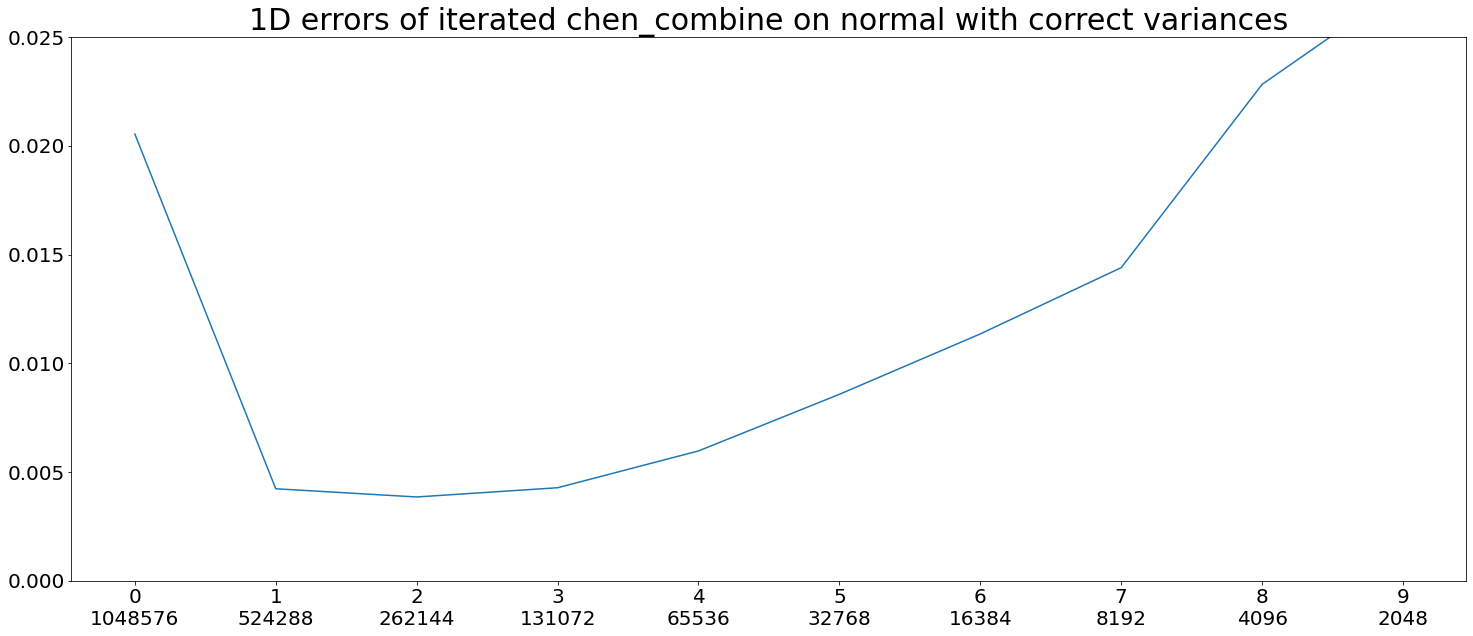

In [8]:
dat1 = iterated_chen_2mom_err
#dat2 = joint_time_3d

fig, ax1 = plt.subplots(1, 1, figsize=(25, 10))
#ax2.set_xlabel("log_2(batch size)", size = 20)
#ax1.set_xlabel("Applications of chen_combine\n batch_size", size = 25)
#ax2.tick_params(labelsize = 20)
ax1.set_ylim([0,0.025])
#ax2.set_ylim([0,21])
#ax1.tick_params(labelsize = 20)
labels = [f"{i}\n{2**(20-i)}" for i in range(len(dat1))]
ax1.set_xticks(ticks=range(len(dat1)), labels=labels, size=20)
ax1.tick_params(labelsize = 20)
ax1.set_title("1D errors of iterated chen_combine on normal with correct variances", size=30)
ax1.plot(dat1)
#ax2.set_title("Time to compute", size = 30)
#ax2.plot(dat2)
#ax2.legend(prop={'size': 15})

fig.show()

In [4]:
# Calculate E[ A^2 | W ] = 1/12 * (1 + (W_1)^2 + (W_2)^2)

def true_second_moments(_w):
    _w_dim = len(_w)
    _w_squared = [x*x for x in _w]
    _a_dim = int((_w_dim - 1)*_w_dim/2)
    moms = []
    for k in range(_w_dim):
        for l in range(k+1,_w_dim):
            moms.append((1.0/12.0)*(1.0 + _w_squared[k] + _w_squared[l]))
    assert len(moms) == _a_dim
    return np.diag(moms)


def empirical_second_moments(_a_generated: np.ndarray):

    _batch_dim = _a_generated.shape[0]
    const = 1.0/_batch_dim
    _a_dim = _a_generated.shape[1]
    result = np.zeros((_a_dim,_a_dim))
    for i in range(_a_dim):
        for j in range(i, _a_dim):
            result[i,j] = const * np.dot(_a_generated[:,i], _a_generated[:,j])
            if i != j:
                result[j,i] = result[i,j]

    return result



def avg_st_dev_error(_w, _a_generated):
    difference = np.abs(np.sqrt(true_second_moments(_w)) - np.sqrt(np.abs(empirical_second_moments(_a_generated))))
    return difference.mean()

def empirical_variances(_a_generated):
    return np.diagonal(empirical_second_moments(_a_generated))

In [5]:
w_dim = 5
a_dim = 10
w_fixed = [1.0,-0.5,-1.2,-0.3,0.7]

# test_filename = f"samples/fixed_samples_{w_dim}-dim.csv"
# A_fixed_true = np.genfromtxt(test_filename,dtype=float,delimiter=',',)
# A_fixed_true = A_fixed_true[:,w_dim:(w_dim+a_dim)]
A_fixed_true = np.zeros((10,10))



a = true_second_moments(w_fixed)
b = empirical_second_moments(A_fixed_true)
c = empirical_variances(A_fixed_true)
print(np.diagonal(a))
# print(b)
print(c)
print(avg_st_dev_error(w_fixed,A_fixed_true))

[0.1875     0.28666667 0.17416667 0.2075     0.22416667 0.11166667
 0.145      0.21083333 0.24416667 0.13166667]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.043458536658709475


In [12]:
filename = f'model_saves/blubiran.txt'

with open(filename, 'a+') as summary_file:
    summary_file.seek(0)
    lines = summary_file.read().splitlines()
    if lines == []:
        serial_num = 1
        summary_file.write(str(serial_num))
    else:
        last_line = lines[-1]
        serial_num = int(last_line)

    summary = f" descriptor: " + "report" + f"\n{serial_num + 1}"
    summary_file.write(summary)



In [9]:
beta1 = 0.2
beta2 = 0.95
print(f"beta1_{beta1:.2f}_beta2_{beta2:.3f}")

beta1_0.20_beta2_0.950
